In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
from scipy.stats import shapiro, normaltest 
from scipy.stats import probplot

CPU times: user 281 ms, sys: 23.4 ms, total: 304 ms
Wall time: 349 ms


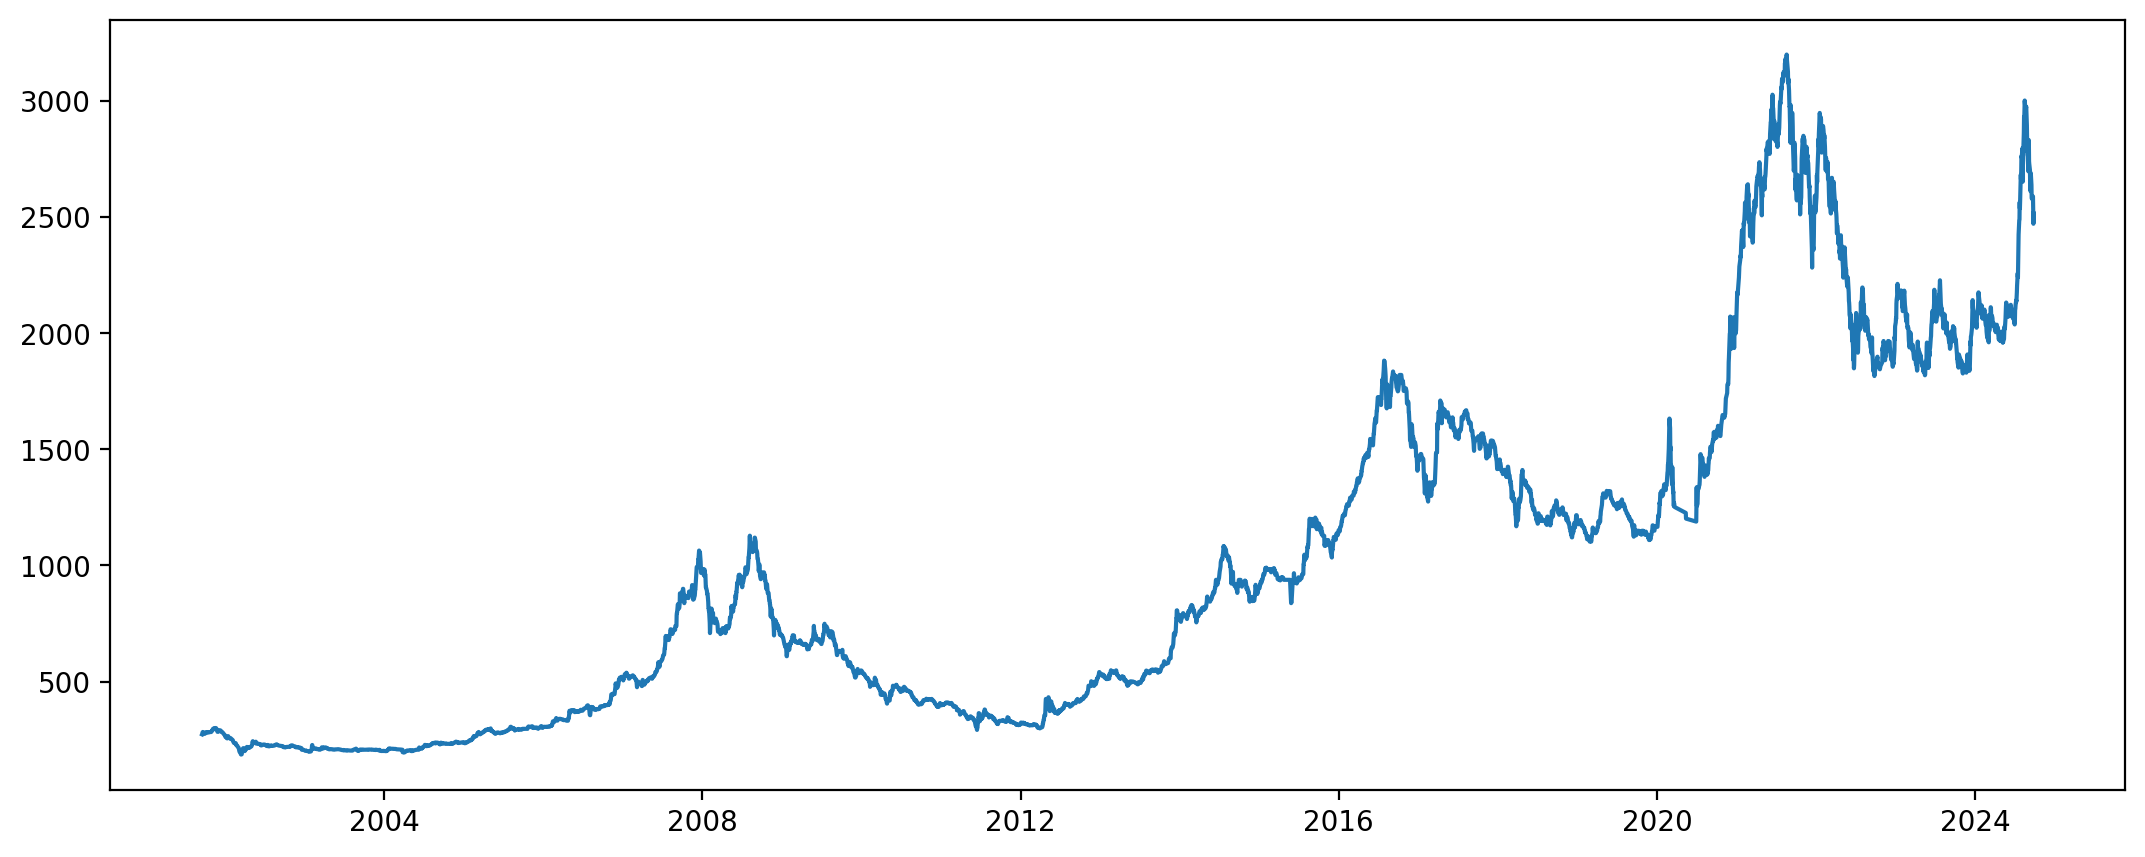

In [71]:
%%time
%config InlineBackend.figure_format = 'retina'
df = pd.read_excel('/Users/praj/Desktop/Hard drive folders/Nepse/nepse_vs_sp500 (updated).xlsx')
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
nepse = pd.DataFrame(df.NEPSE)
plt.figure(figsize=(13,5))
plt.plot(nepse)

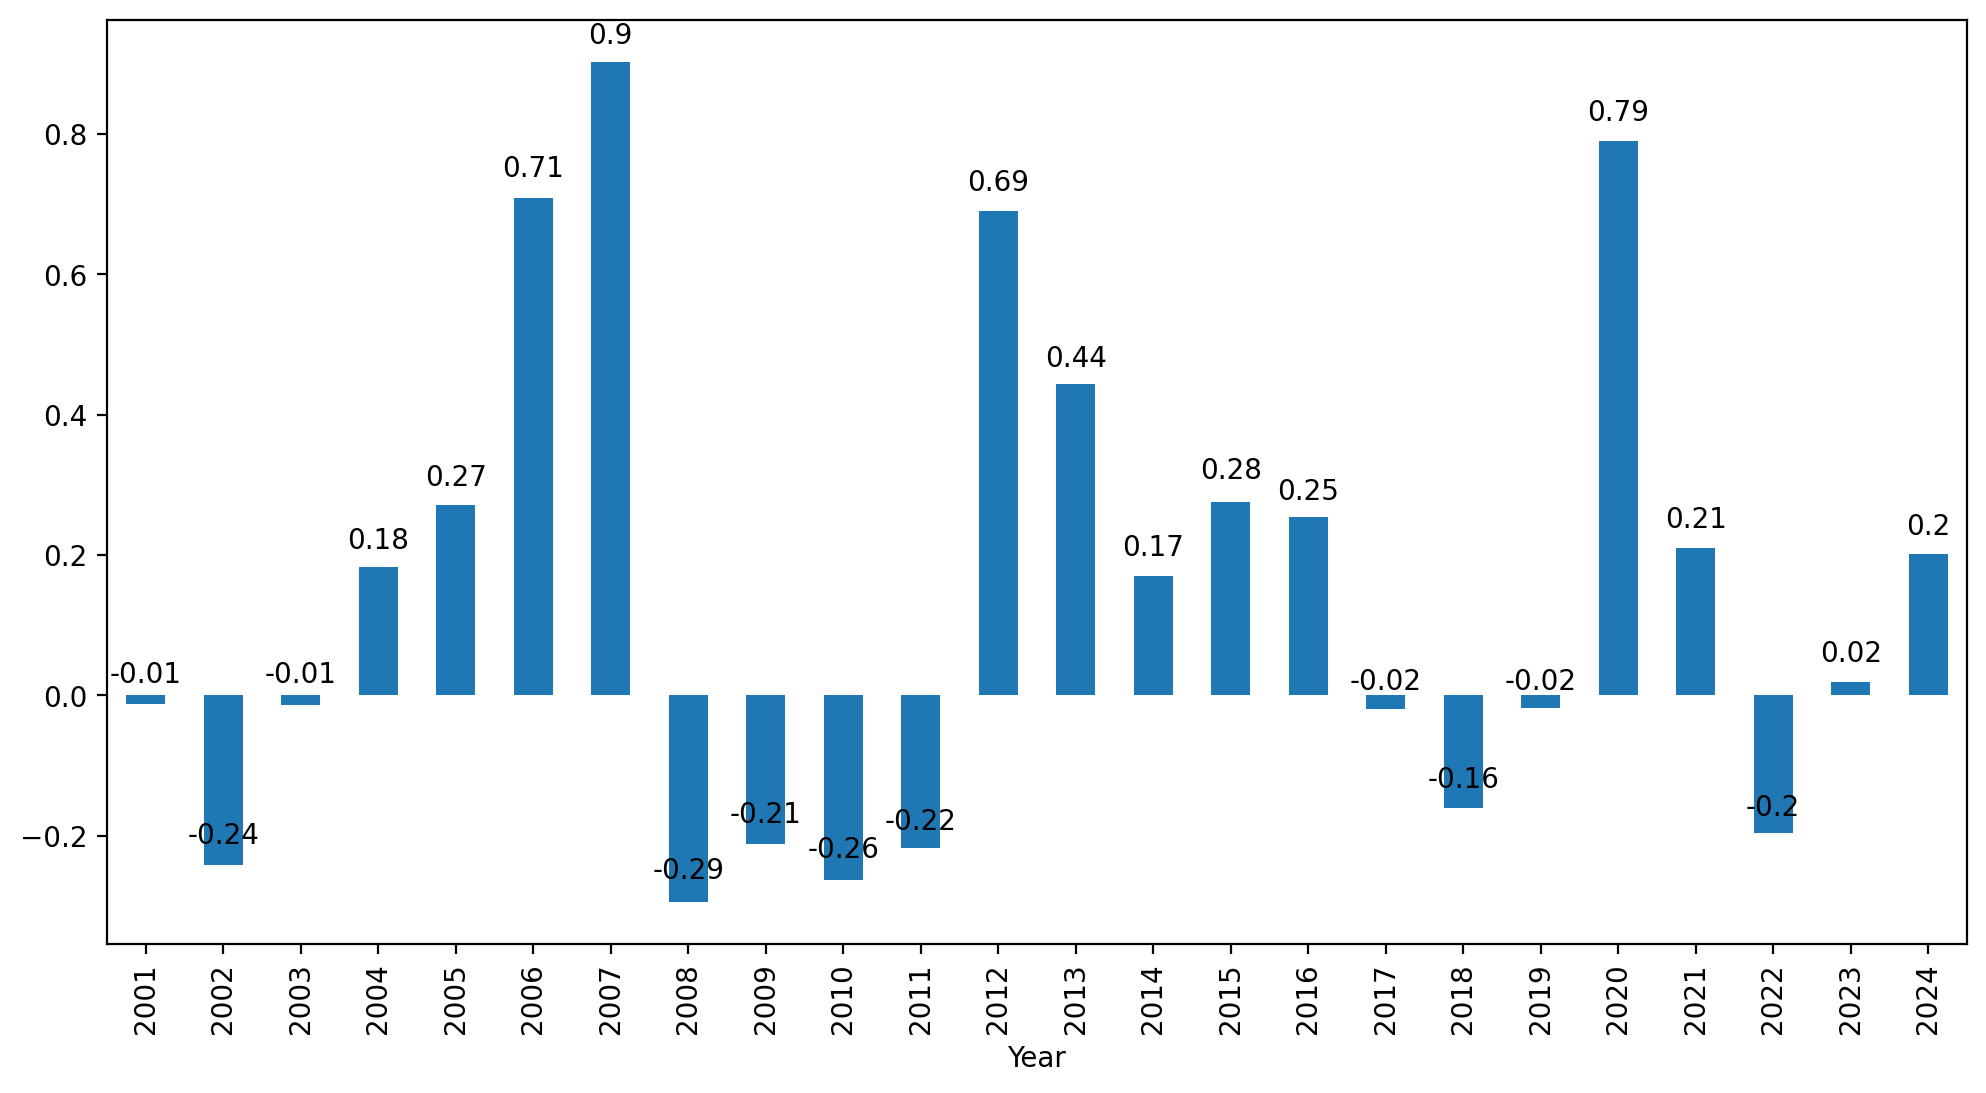

In [72]:
# groupby year and determine the daily percent change by year, and add it as a column to df
nepse['returns'] = nepse.NEPSE.pct_change()
nepse['log_returns'] = np.log(nepse['NEPSE']/nepse['NEPSE'].shift(1))
nepse['year'] = nepse.index.year
nepse['month'] = nepse.index.month
nepse['day_of_the_month'] = nepse.index.day

grouped_by_day = nepse.groupby('day_of_the_month').log_returns.mean()
grouped_by_month = nepse.groupby('month').log_returns.mean()
grouped_by_year = nepse.groupby('year').log_returns.mean()

day_returns = nepse.groupby('day_of_the_month').returns.sum()
month_returns = nepse.groupby('month').returns.sum()
yearly_returns = nepse.groupby('year').returns.sum()

ann_log_rets = nepse.groupby('year').log_returns.sum()

cumulative_yearly_rets = pd.DataFrame(nepse['NEPSE'].pct_change().resample('Y').agg(lambda x: (1+x).prod()-1))
cumulative_yearly_rets['Year'] = cumulative_yearly_rets.index.year
cumulative_yearly_rets = cumulative_yearly_rets.set_index(cumulative_yearly_rets.Year)
cumulative_yearly_rets.NEPSE.plot.bar(figsize=(12,6))

# Add values above the bars
for i, v in enumerate(cumulative_yearly_rets.NEPSE.round(2)):
    plt.text(i, v+0.02, str(v), ha='center', va='bottom')

## Get expected (annualized) returns

In [73]:
def getExpectedReturns(df, price_col_name, annualised=True, frequency='daily'):
    
    daily_returns = df[price_col_name].pct_change()
    weekly_returns = df[price_col_name].resample('W').mean().pct_change()
    monthly_returns = df[price_col_name].resample('M').mean().pct_change()
    
    exp_daily_return = daily_returns.mean()
    exp_weekly_return = weekly_returns.mean()
    exp_monthly_return = monthly_returns.mean()
    
    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12
    
    if annualised == True:
        if frequency == 'daily':
            annualised_return = (1+exp_daily_return)**daily_frequency - 1
        elif frequency == 'weekly':
            annualised_return = (1+exp_weekly_return)**weekly_frequency - 1
        elif frequency == 'monthly':
            annualised_return = (1+exp_monthly_return)**monthly_frequency - 1
            
        return annualised_return
    else:
        if frequency == 'weekly':
            return exp_weekly_return
        elif frequency == 'monthly':
            return exp_monthly_return
    
    return exp_daily_return



def getAnnualisedStd(df, col_name, return_frequency='daily'):
    daily_returns = df[col_name].pct_change()
    weekly_returns = df[col_name].resample('W').ffill().pct_change()
    monthly_returns = df[col_name].resample('M').ffill().pct_change() 
    
    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12
    
    if return_frequency == 'daily':
        var = np.var(daily_returns)
        std = np.std(daily_returns)
        annualised_std = std*np.sqrt(daily_frequency)
        return annualised_std
    elif return_frequency == 'weekly':
        var = np.var(weekly_returns)
        std = np.std(weekly_returns)
        annualised_std = std*np.sqrt(weekly_frequency)
        return annualised_std
    elif return_frequency == 'monthly':
        var = np.var(monthly_returns)
        std = np.std(monthly_returns)
        annualised_std = std*np.sqrt(monthly_frequency)
        return annualised_std

In [74]:
print('annualized returns: ' + str(getExpectedReturns(nepse, 'NEPSE', annualised=True, frequency='daily')))
print('annualized volatility: ' + str(getAnnualisedStd(nepse, 'NEPSE', return_frequency='daily')))

annualized returns: 0.12418381493726649
annualized volatility: 0.1984879640881087


/var/folders/lc/p6rpdt515h9b47v6f_756gnc0000gn/T/ipykernel_57820/3770068787.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_returns = df[price_col_name].resample('W').mean().pct_change()
/var/folders/lc/p6rpdt515h9b47v6f_756gnc0000gn/T/ipykernel_57820/3770068787.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_returns = df[price_col_name].resample('M').mean().pct_change()


## Returns Histogram

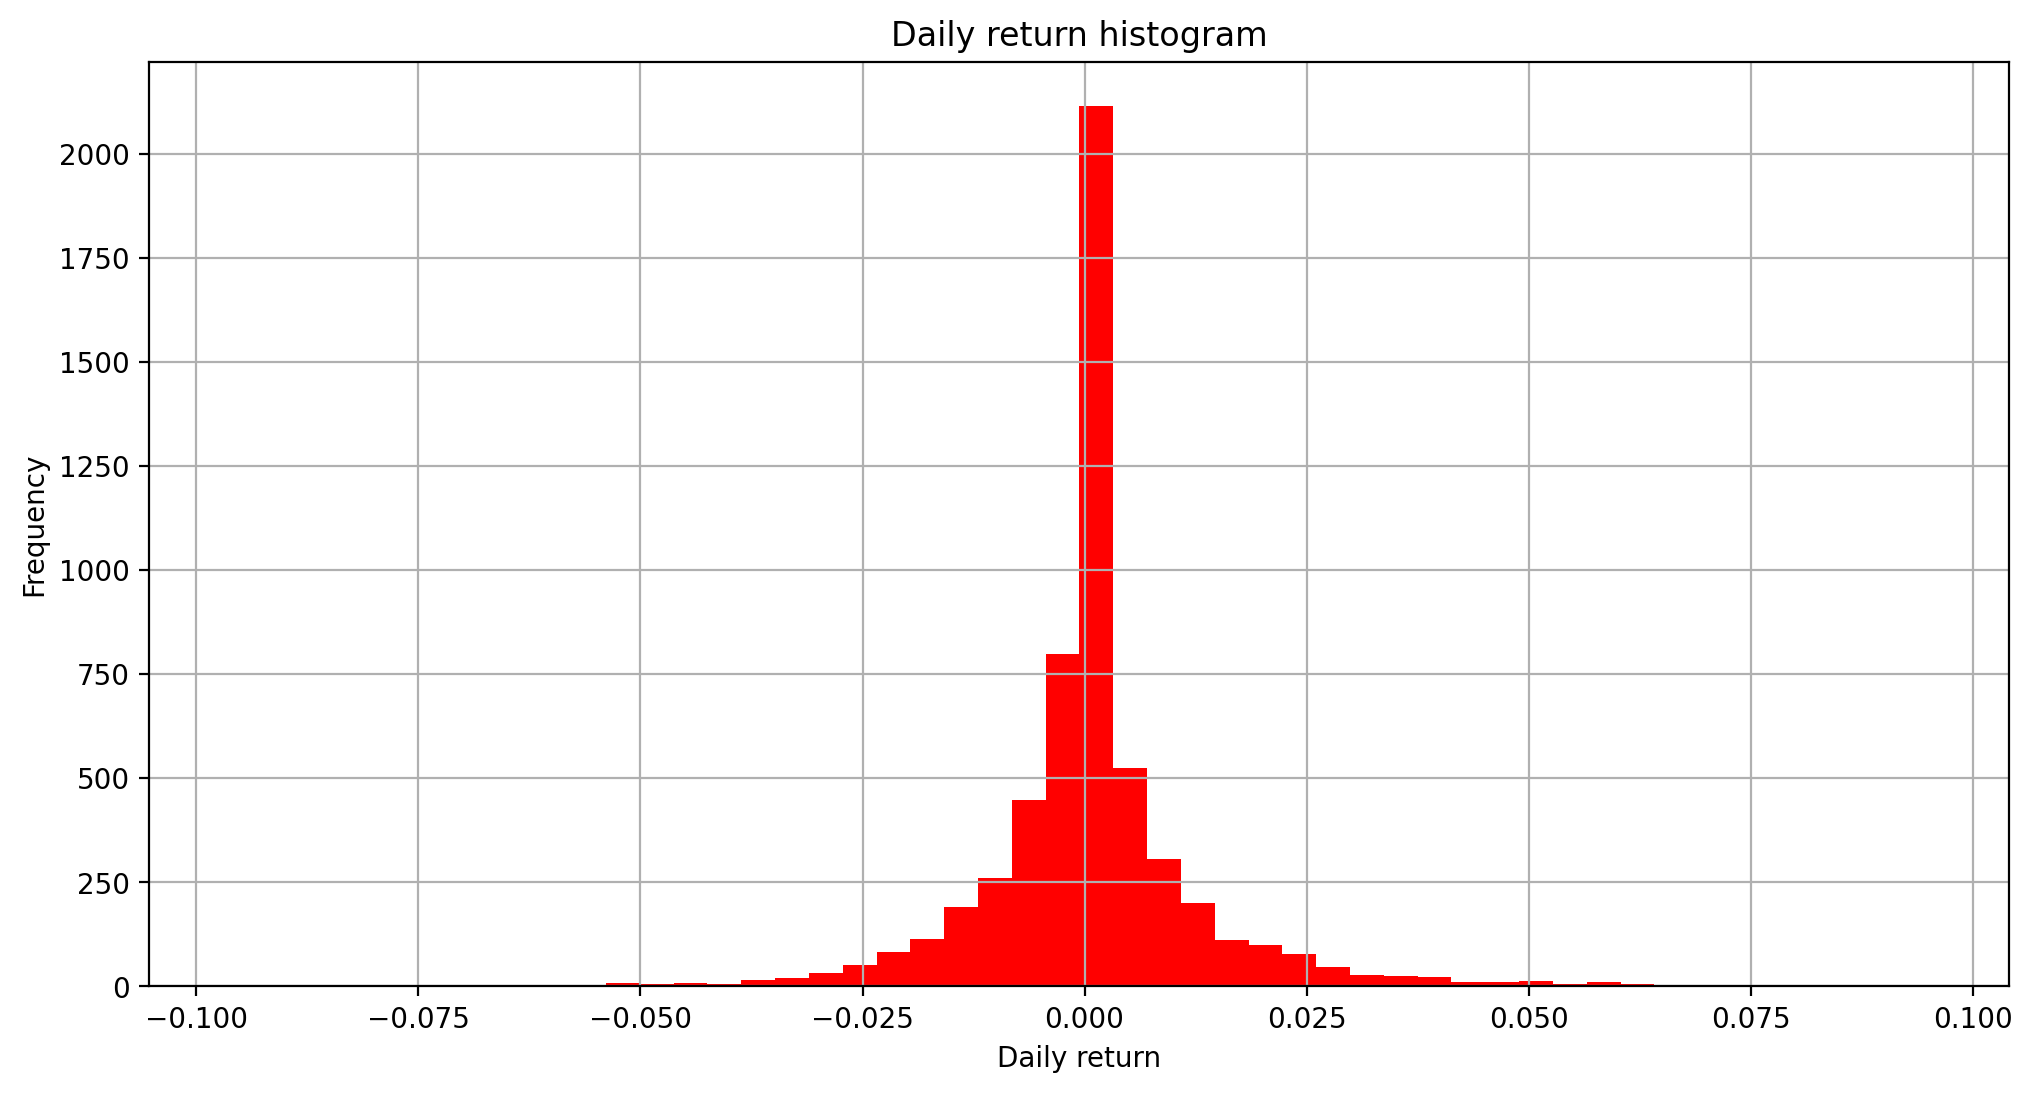

In [75]:
# Plot the histogram
nepse['returns'].hist(bins=50, color='red', figsize=(12,6))
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

In [76]:
# test for normal distribution
# Perform Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = shapiro(nepse.returns.dropna())
print(f"Shapiro-Wilk Test: Statistic = {shapiro_test_statistic}, p-value = {shapiro_p_value}")

# Perform D'Agostino and Pearson's test
k2, p = normaltest(nepse.returns.dropna())
print(f"D'Agostino and Pearson's Test: Statistic = {k2}, p-value = {p}")

Shapiro-Wilk Test: Statistic = 0.8506034016609192, p-value = 0.0
D'Agostino and Pearson's Test: Statistic = 1108.9568504924798, p-value = 1.5598383051197388e-241


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In both tests, the null hypothesis is that the data is normally distributed. If the p-value is greater than a chosen significance level (e.g., 0.05), you fail to reject the null hypothesis, indicating that the data may be normally distributed. However, if the p-value is below the significance level, you reject the null hypothesis, suggesting that the data does not follow a normal distribution.

Keep in mind that stock returns often exhibit characteristics like fat tails and excess kurtosis, which make them deviate from a perfect normal distribution. Even if the p-values are significant, it's essential to interpret the results carefully and consider the underlying characteristics of financial data. Additionally, visualizations, such as the histogram and Q-Q plots, can provide valuable insights into the distribution's behavior.

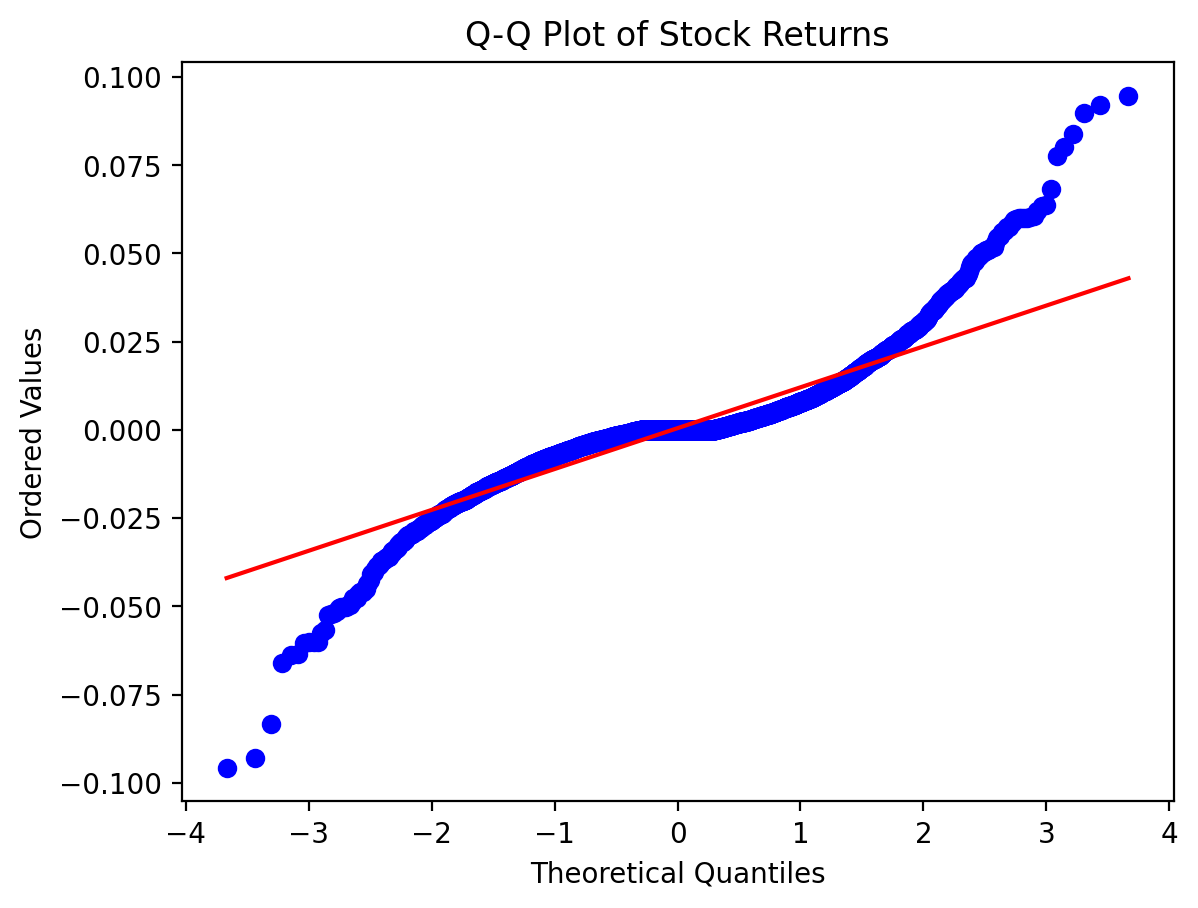

In [77]:
# Plot the Q-Q plot of stock returns against the normal distribution
probplot(nepse.returns.dropna(), plot=plt)
plt.title('Q-Q Plot of Stock Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

## Volatility 

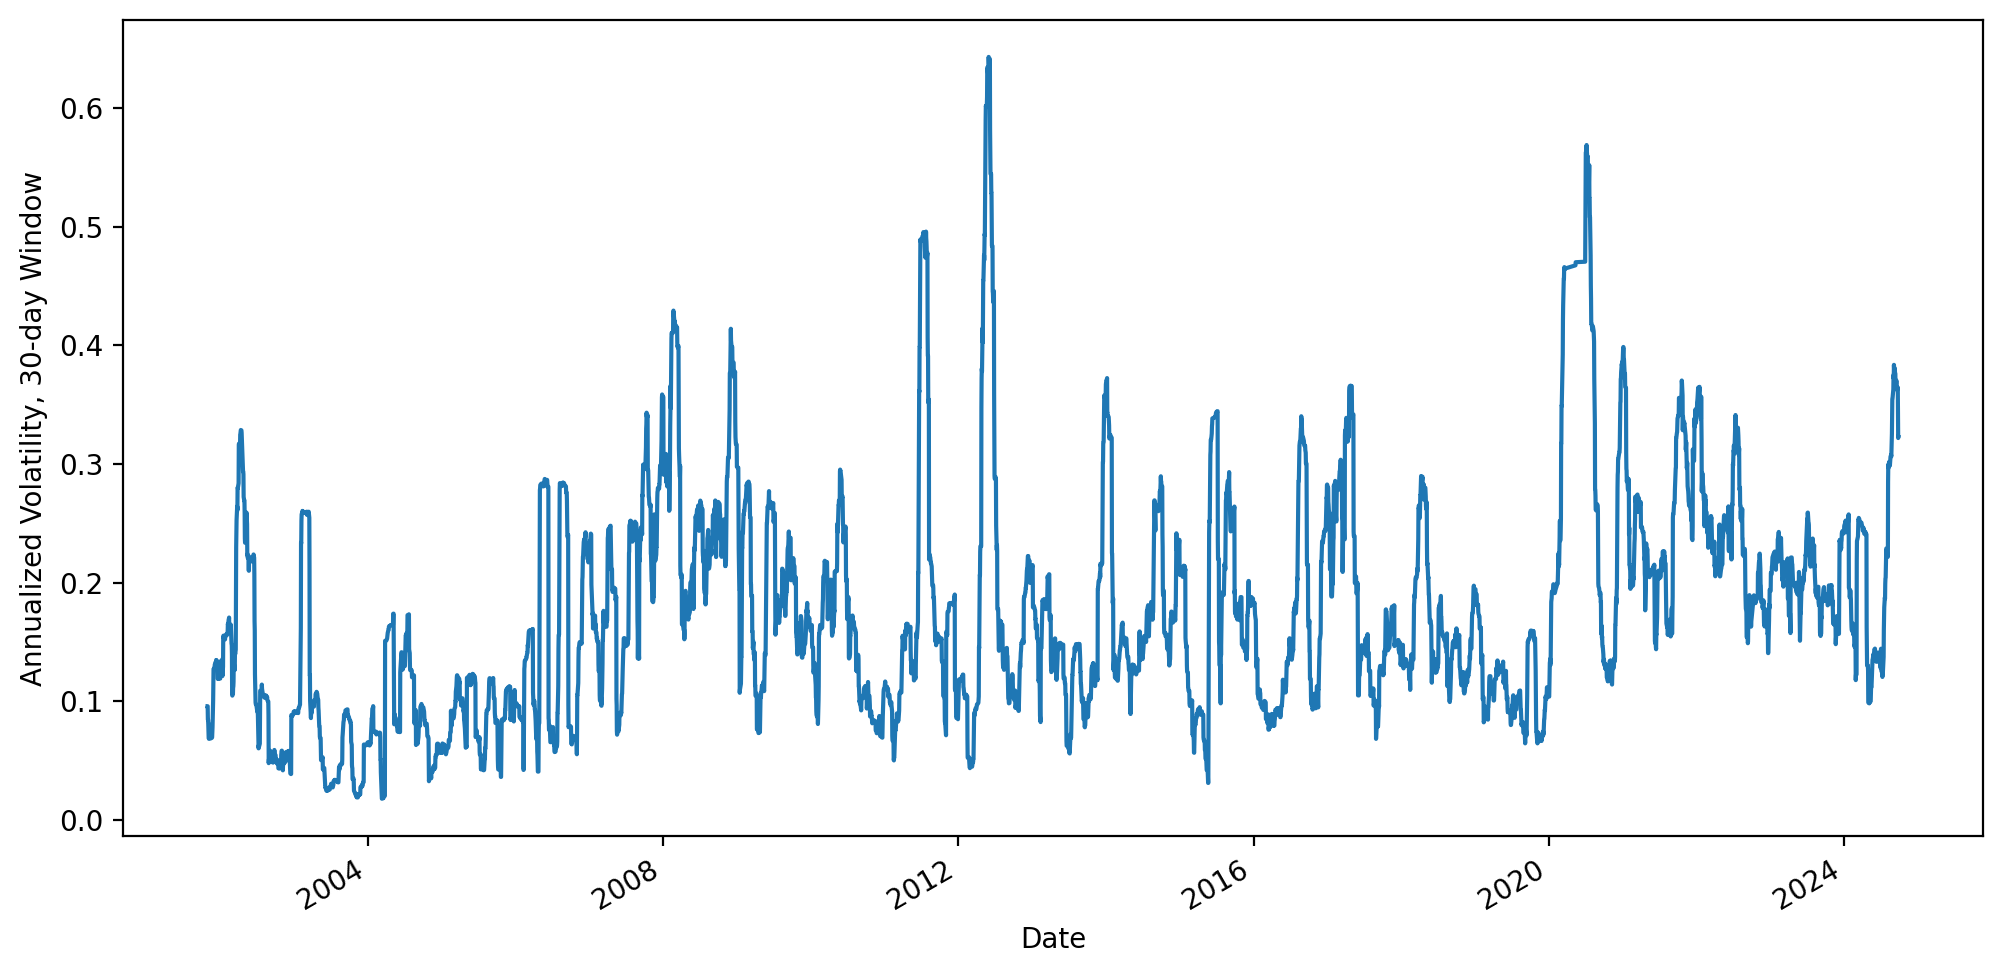

In [79]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = nepse.returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the index volatility
volatility_series.plot(figsize=(12,6)).set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

## VaR

In [80]:
from scipy.stats import norm

mlt_mean = np.mean(nepse.NEPSE.resample('M').ffill().pct_change())
mlt_std = np.std(nepse.NEPSE.resample('M').ffill().pct_change())

VaR_90 = norm.ppf(1-0.9, mlt_mean, mlt_std)
VaR_95 = norm.ppf(1-0.95, mlt_mean, mlt_std)
VaR_99 = norm.ppf(1-0.99, mlt_mean, mlt_std)

print(VaR_90)
print(VaR_95)
print(VaR_99)

-0.08722708637112309
-0.11501743685451107
-0.16714751259833105


## Drawdown

In [81]:
def drawdown(rets: pd.Series):
    """
    Takes a timeseries of asset returns
    Computes and returns dataframe that contains:
    the wealth index
    previous peaks
    percentage drawdown
    """
    wealth_index = 1*(1+rets).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, "Peaks":previous_peaks, "Drawdowns": drawdowns})

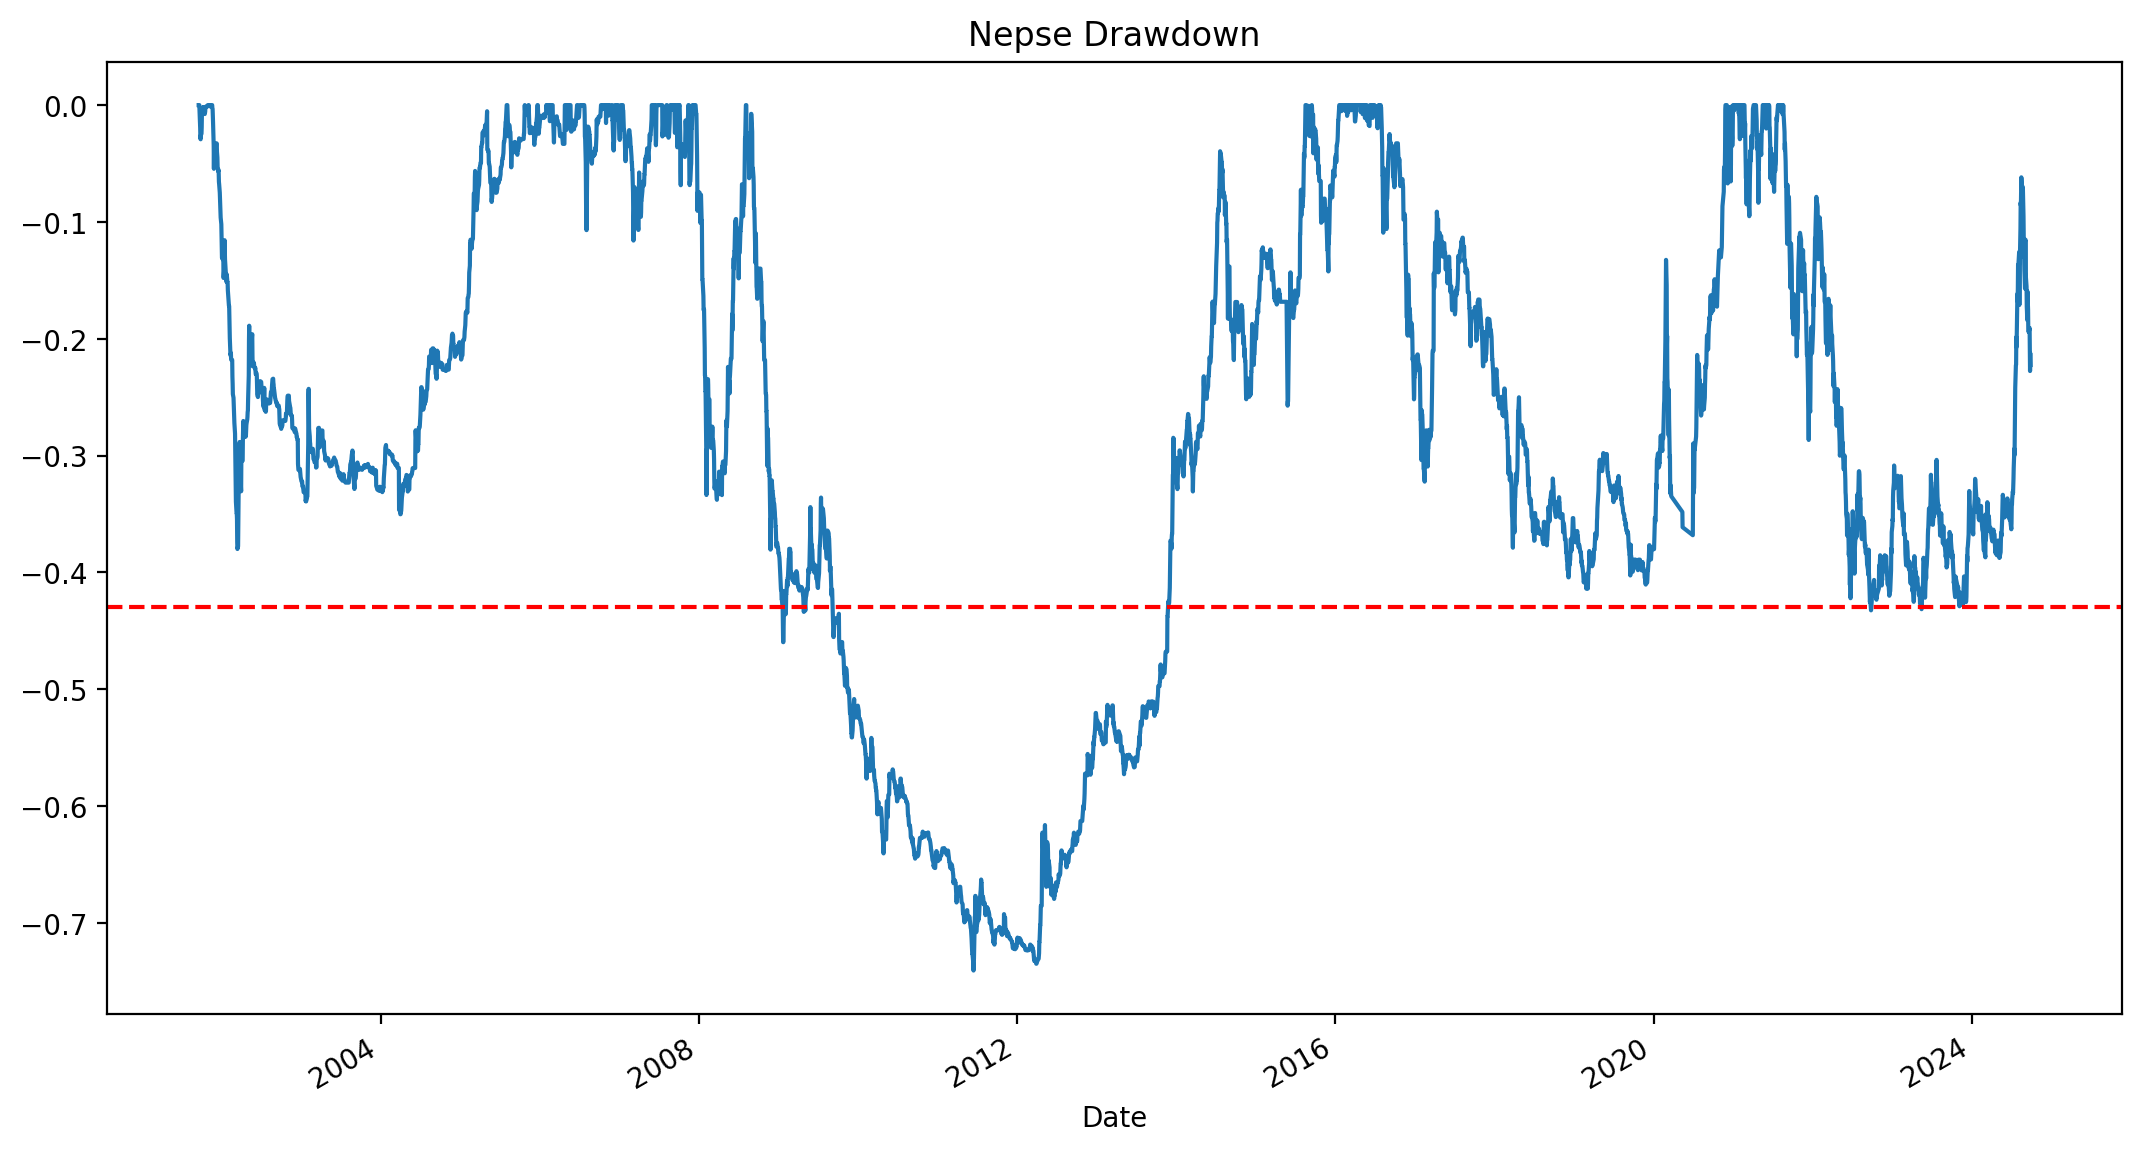

In [82]:
drawdown(nepse.returns).Drawdowns.plot(title='Nepse Drawdown', figsize=(13,7))
plt.axhline(y=-.43, color='r', linestyle='--')

In [83]:
drawdown(nepse.returns)

,Wealth,Peaks,Drawdowns
Date,,,
2001-09-17,NaN,NaN,NaN
2001-09-18,1.007765,1.007765,0.000000
2001-09-19,1.025310,1.025310,0.000000
2001-09-20,1.025310,1.025310,0.000000
2001-09-21,1.037984,1.037984,0.000000
...,...,...,...
2024-09-22,9.480788,11.716054,-0.190787
2024-09-23,9.264606,11.716054,-0.209238
2024-09-24,9.048716,11.716054,-0.227665


In [84]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    
    def annualize_rets(r, periods_per_year):
        compounded_growth = (1+r).prod()
        n_periods = r.shape[0]
        return compounded_growth**(periods_per_year/n_periods)-1

    def annualize_vol(r, periods_per_year):
        return r.std()*(periods_per_year**0.5)

    #def sharpe_ratio(r, riskfree_rate, periods_per_year):
    # convert the annual riskfree rate to per period
     #   rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
     #   excess_ret = r - rf_per_period
     #   ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
     #   ann_vol = annualize_vol(r, periods_per_year)
     #   return ann_ex_ret/ann_vol
        
    #ann_r1=annualize_rets(nepse.returns, periods_per_year=250)
    #ann_vol1=annualize_vol(nepse.returns, 250)

    ann_r = r.aggregate(annualize_rets(nepse.returns, periods_per_year=250))
    ann_vol = r.aggregate(annualize_vol(nepse.returns, 250))
    #ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    #dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    #skew = r.aggregate(skewness)
    #kurt = r.aggregate(kurtosis)
    #cf_var5 = r.aggregate(var_gaussian, modified=True)
    #hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": [ann_r1],
        "Annualized Vol": [ann_vol1],
        #"Skewness": skew,
        #"Kurtosis": kurt,
        #"Cornish-Fisher VaR (5%)": cf_var5,
        #"Historic CVaR (5%)": hist_cvar5,
       # "Sharpe Ratio": ann_sr,
        #"Max Drawdown": dd
    })


# Comparing it with S&P 500

In [21]:
pip install yfinance


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [85]:
import yfinance as yf
sp = yf.download('^GSPC', start='2001-09-17')['Adj Close']
sp_df = pd.DataFrame(sp)
merge_df = pd.merge(nepse.NEPSE, sp_df, left_index = True, right_index=True)
merge_df.rename(columns={'Adj Close':'S&P500'}, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [86]:
mlt_ret_df = merge_df.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)

In [87]:
import edhec_risk_kit as erk
erk.summary_stats(mlt_ret_df)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish_Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
NEPSE,0.100436,0.263741,0.867441,5.518079,0.140766,0.193277,0.259626,-0.733051
S&P500,0.076909,0.153851,-0.605886,5.225963,0.132639,0.156864,0.296558,-0.525559


<Axes: xlabel='Date'>

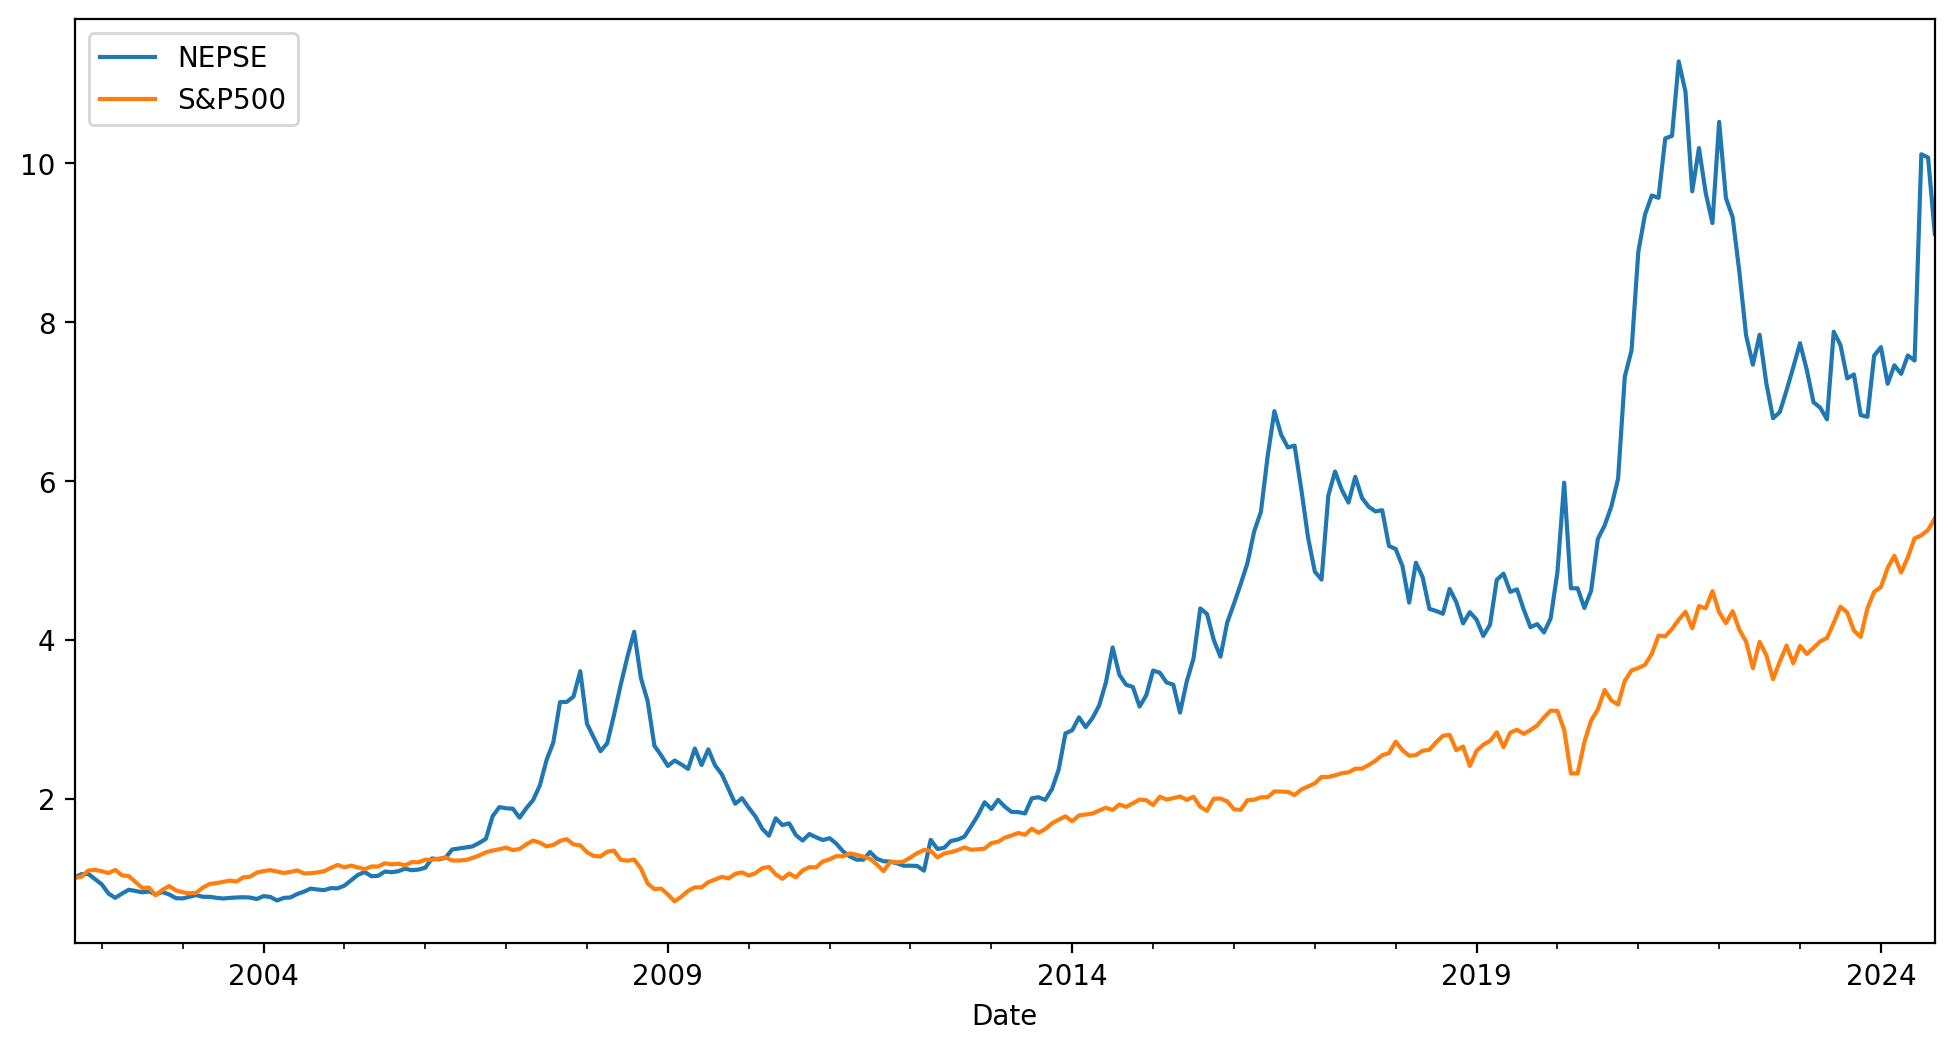

In [88]:
(1+mlt_ret_df).cumprod().plot(figsize=(12,6))

## 2024 Nepse monthly performance

/var/folders/lc/p6rpdt515h9b47v6f_756gnc0000gn/T/ipykernel_57820/2035372100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nepse_2024['returns'] = nepse_2024['NEPSE'].pct_change()
/var/folders/lc/p6rpdt515h9b47v6f_756gnc0000gn/T/ipykernel_57820/2035372100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nepse_2024['year'] = nepse_2024.index.year
/var/folders/lc/p6rpdt515h9b47v6f_756gnc0000gn/T/ipykernel_57820/2035372100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

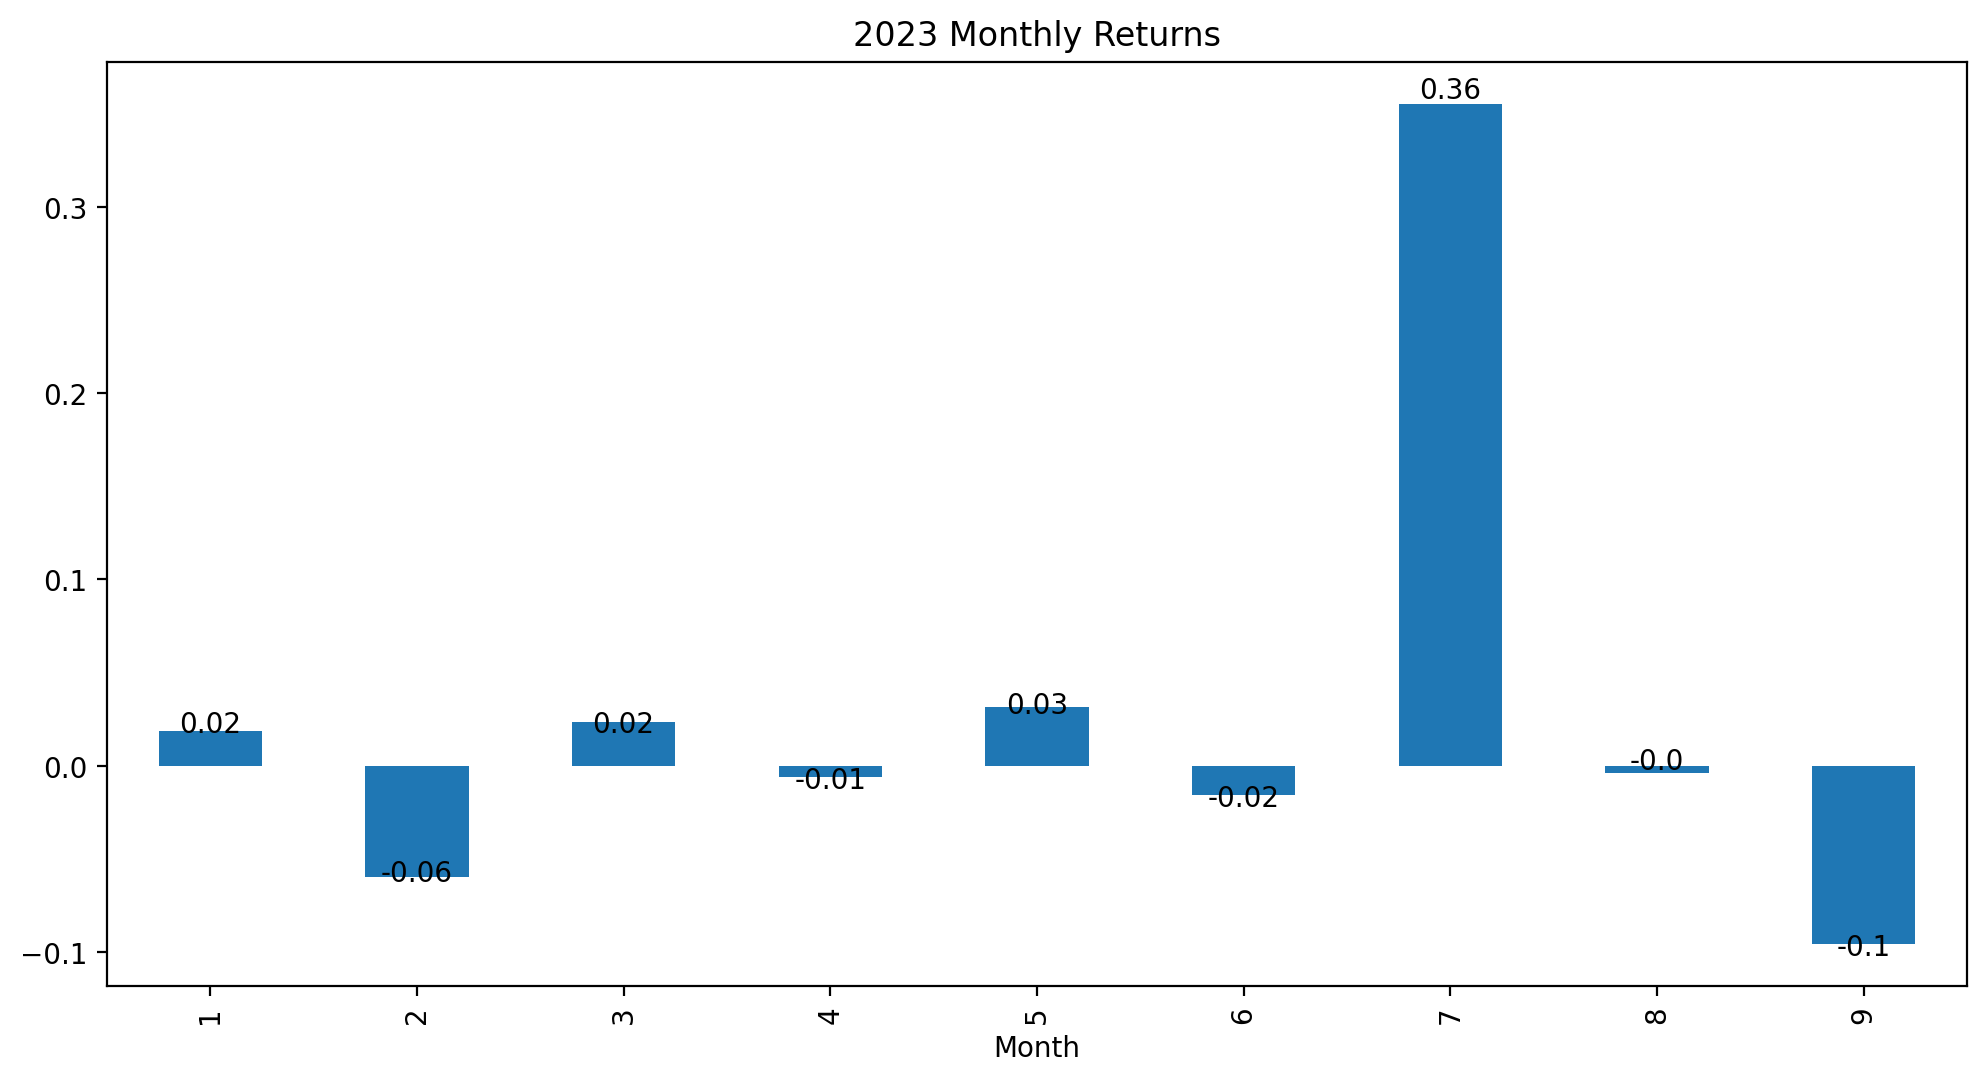

In [89]:
nepse_2024 = nepse.loc['2023-12-31': ]
nepse_2024['returns'] = nepse_2024['NEPSE'].pct_change()
nepse_2024['year'] = nepse_2024.index.year
nepse_2024['month'] = nepse_2024.index.month
nepse_2024['day_of_the_month'] = nepse_2024.index.day


cum_mlt_rets = pd.DataFrame(nepse_2024['NEPSE'].pct_change().resample('M').agg(lambda x: (1+x).prod()-1))
cum_mlt_rets['Month'] = cum_mlt_rets.index.month
cum_mlt_rets = cum_mlt_rets.set_index(cum_mlt_rets.Month)
cum_mlt_rets['NEPSE'].plot.bar(figsize=(12,6), title='2023 Monthly Returns')


# Add values above the bars
for i, v in enumerate(cum_mlt_rets.NEPSE.round(2)):
    plt.text(i, v+0.01, str(v), ha='center', va='top')

<Axes: title={'center': '2024 Monthly Volatility'}, xlabel='Month'>

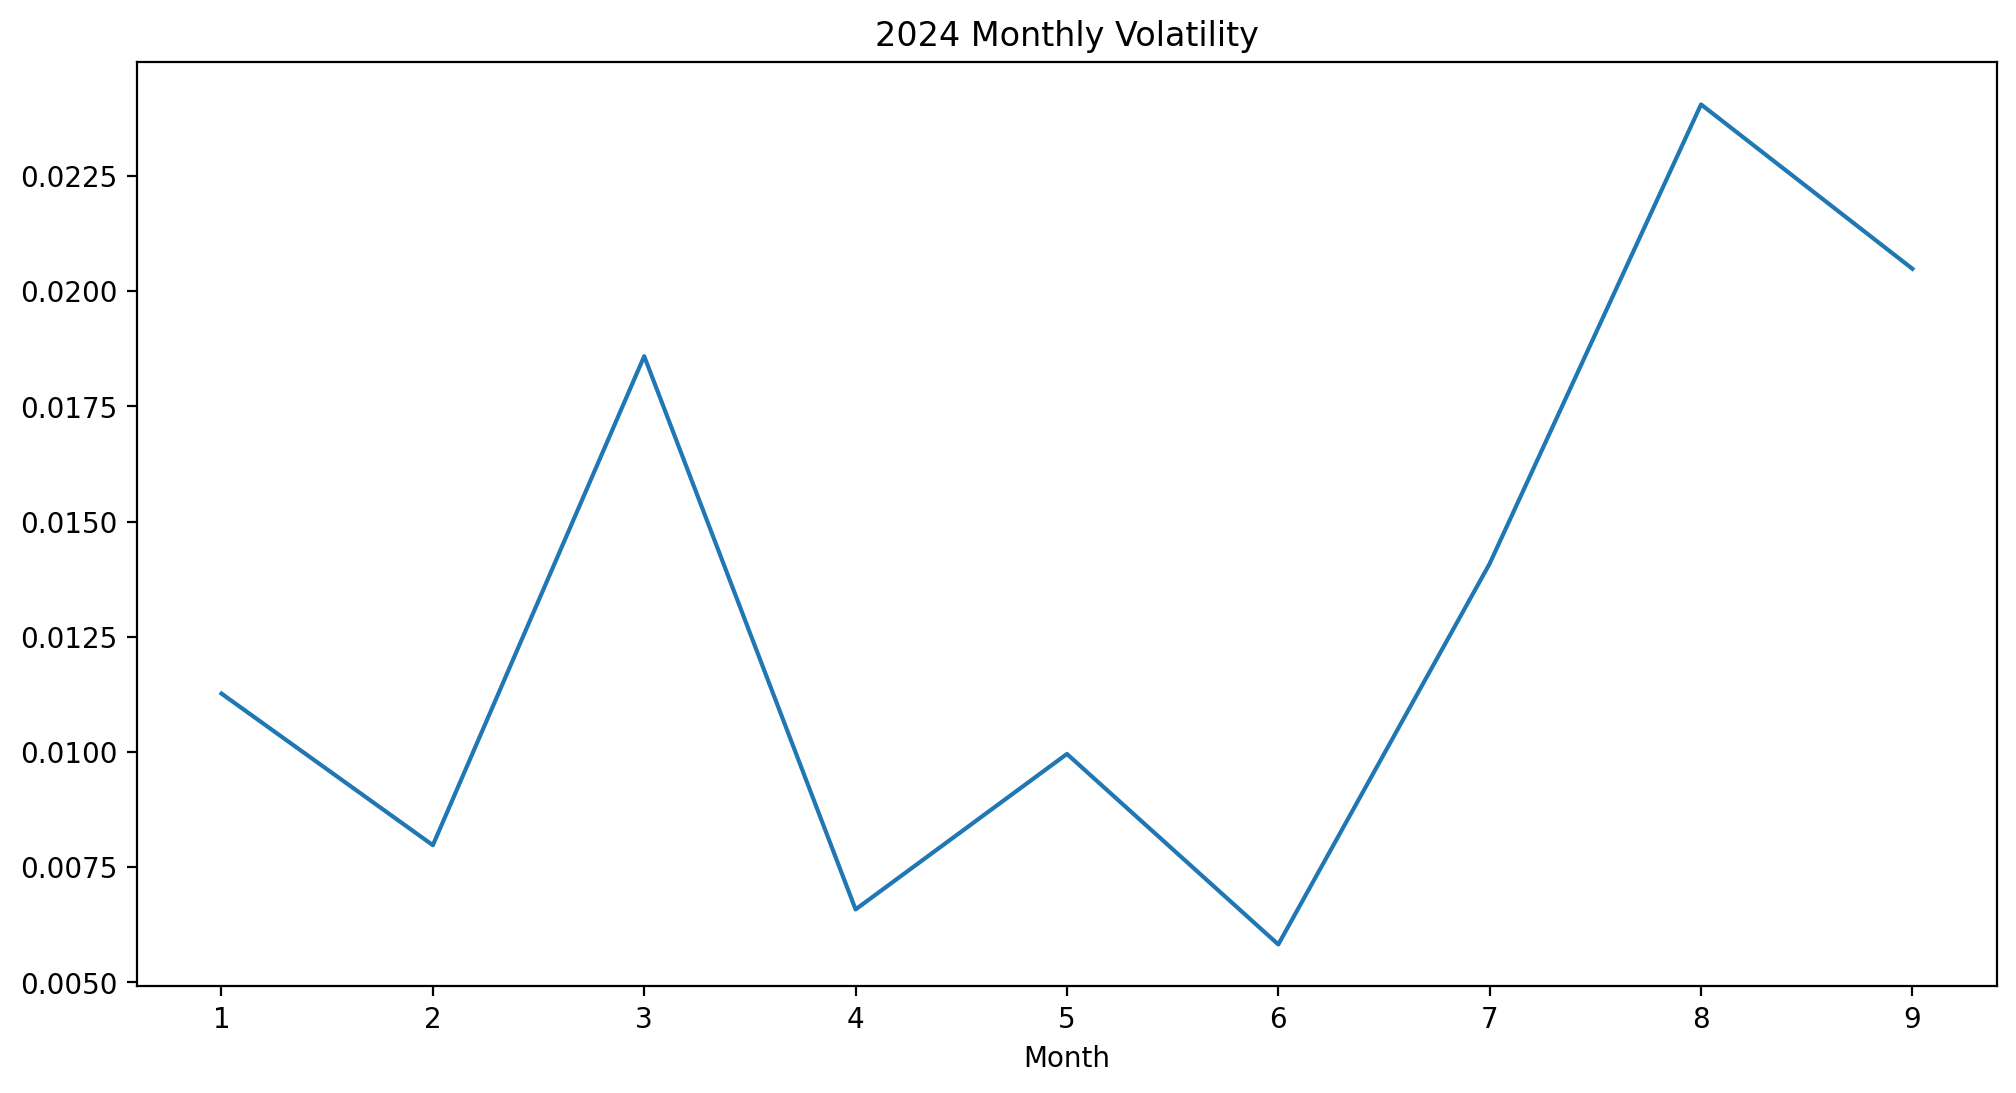

In [90]:
# get monthly volatility for 2023
monthly_volatility_2024 = pd.DataFrame(nepse_2024.resample('M')['returns'].std())
monthly_volatility_2024['Month'] = monthly_volatility_2024.index.month
monthly_volatility_2024 = monthly_volatility_2024.set_index(monthly_volatility_2024.Month)
monthly_volatility_2024 = monthly_volatility_2024.rename(columns={'returns': 'Volatility'})
monthly_volatility_2024['Volatility'].plot.line(figsize=(12,6), title='2024 Monthly Volatility')

In [91]:
x = cum_mlt_rets.index
y1 = cum_mlt_rets.NEPSE
y2 = monthly_volatility_2024.Volatility

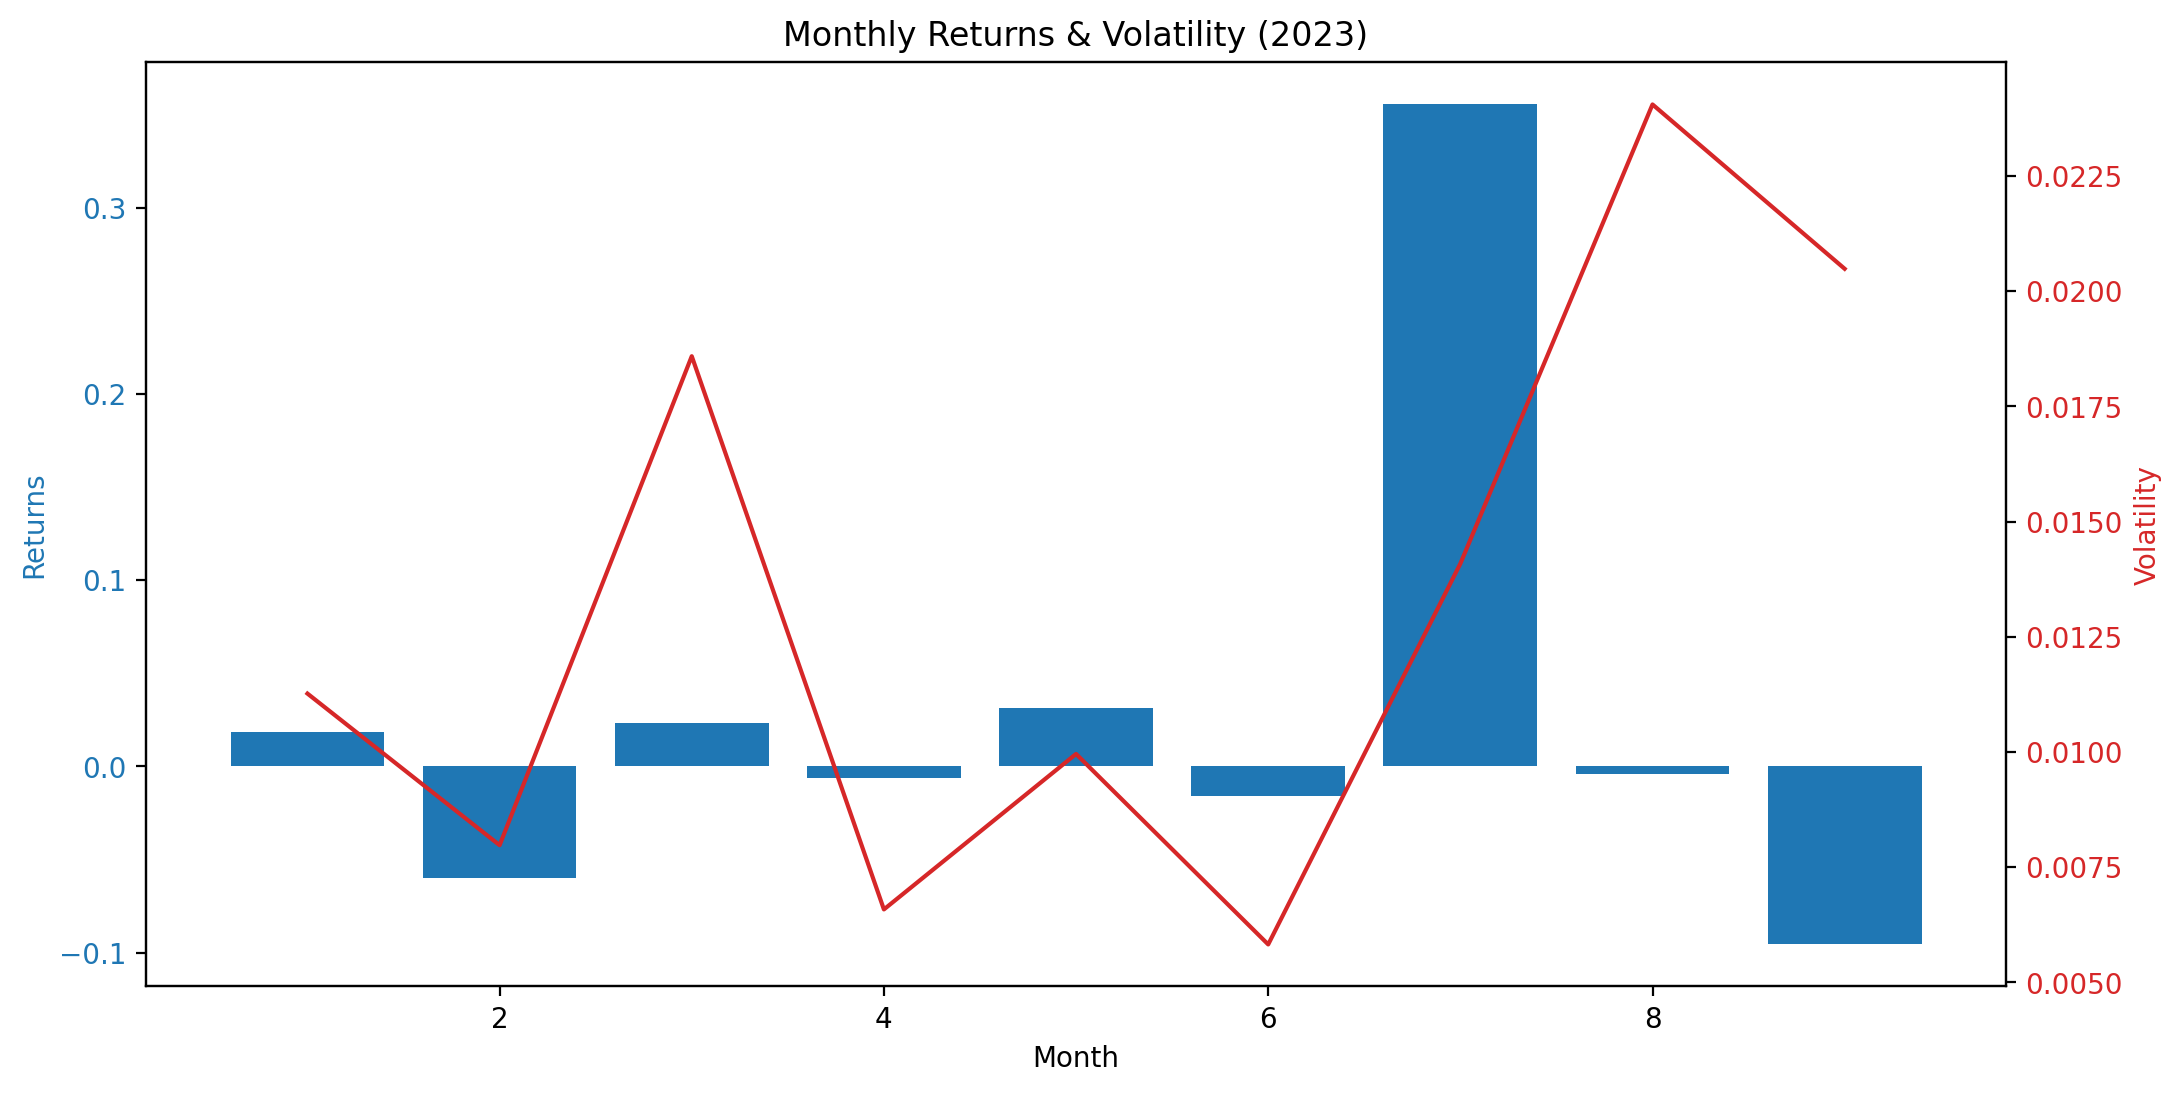

In [92]:
# Create the first plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the first set of data
bars = ax1.bar(x, y1, color='tab:blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Returns', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second set of data
ax2.plot(x, y2, color='tab:red')
ax2.set_ylabel('Volatility', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Show the plot
plt.title('Monthly Returns & Volatility (2023)')
plt.show()

# Add values above the bars
#for bar in bars:
 #   yval = bar.get_height()
  #  ax1.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='tab:blue')

## Nepse: 09-2001 - 09-2023

In [93]:
nepse

,NEPSE,returns,log_returns,year,month,day_of_the_month
Date,,,,,,
2001-09-17,273.01,NaN,NaN,2001,9,17
2001-09-18,275.13,0.007765,0.007735,2001,9,18
2001-09-19,279.92,0.017410,0.017260,2001,9,19
2001-09-20,279.92,0.000000,0.000000,2001,9,20
2001-09-21,283.38,0.012361,0.012285,2001,9,21
...,...,...,...,...,...,...
2024-09-22,2588.35,0.004498,0.004488,2024,9,22
2024-09-23,2529.33,-0.022802,-0.023066,2024,9,23
2024-09-24,2470.39,-0.023303,-0.023578,2024,9,24


In [94]:
# Daily
print(len(nepse.query('returns > 0'))) # daily positive
print(len(nepse.query('returns < 0'))) # daily negative

# Monthly
mlt_rets = pd.DataFrame(nepse.NEPSE.pct_change().resample('M').agg(lambda x: (1+x).prod()-1))
print(len(mlt_rets.query('NEPSE > 0'))) # monthly positive
print(len(mlt_rets.query('NEPSE < 0'))) # monthly negative

# Quaterly
qtr_rets = pd.DataFrame(nepse.NEPSE.pct_change().resample('Q').agg(lambda x: (1+x).prod()-1))
print(len(qtr_rets.query('NEPSE > 0'))) # quaterly positive
print(len(qtr_rets.query('NEPSE < 0'))) # quaterly negative

# Yearly
yer_rets = pd.DataFrame(nepse.NEPSE.pct_change().resample('Y').agg(lambda x: (1+x).prod()-1))
print(len(yer_rets.query('NEPSE > 0'))) # yearly positive
print(len(yer_rets.query('NEPSE < 0'))) # yearly negative

# 5 Yearly
yer5_rets = pd.DataFrame(nepse.NEPSE.pct_change().resample('5A').agg(lambda x: (1+x).prod()-1))
print(len(yer5_rets.query('NEPSE > 0'))) # yearly positive
print(len(yer5_rets.query('NEPSE < 0'))) # yearly negative

# 10 Yearly
yer10_rets = pd.DataFrame(nepse.NEPSE.pct_change().resample('10A').agg(lambda x: (1+x).prod()-1))
print(len(yer10_rets.query('NEPSE > 0'))) # yearly positive
print(len(yer10_rets.query('NEPSE < 0'))) # yearly negative

2173
2215
138
138
50
43
13
11
3
3
2
2


In [123]:
data_frame = {'time frame': ['daily', 'monthly', 'quaterly', 'yearly', '5-yearly', '10-yearly'],
              'positive': [2171/(2212+2171), 138/(138+138), 50/(50+43), 13/(13+11), 3/(3+3), 2/(2+2)],
              'negative': [2212/(2212+2171), 138/(138+138), 43/(50+43), 11/(13+11), 3/(3+3), 2/(2+2)]}

new_df = pd.DataFrame(data_frame).round(2)
new_df

,time frame,positive,negative
0,daily,0.50,0.50
1,monthly,0.50,0.50
2,quaterly,0.54,0.46
3,yearly,0.54,0.46
4,5-yearly,0.50,0.50
5,10-yearly,0.50,0.50


# NEPSE vs Gold v Silver

In [160]:
# initialize list of lists
data_set = [['03-1-2010', 549, 'nan' ,26882, 'nan', 437, 'nan'], ['02-01-2011', 401, -0.2702, 34595, 0.2039, 755, 0.0830 ], ['02-01-2012', 324, -0.1913, 45578, 0.2185, 870, 0.0990], ['01-01-2013', 531, 0.5479, 50658, 0.0205, 948, 0.0910], 
            ['01-01-2014', 754, 0.3479, 44458, -0.1224, 720, 0.0721], ['01-01-2015', 904, 0.0997, 44372, -0.0019, 592, 0.0992], ['04-01-2016', 1154, 0.2318, 41358, -0.0679, 579, 0.0447], ['01-01-2017', 1466, 0.2286, 45402, 0.0563, 647, 0.0415], ['01-01-2018', 1435, -0.0211, 47925, 0.0092, 643, 0.0464],
            ['01-01-2019', 1186, -0.1735, 51185, 0.0065, 639, 0.0615], ['01-01-2020', 1170, -0.0138, 63015, 0.1951, 763, 0.0360], ['03-01-2021', 2175, 0.7966, 81020, 0.2225, 1115, 0.0632], ['02-01-2022', 2585, 0.1111, 81020, -0.0117, 1089, 0.0774], ['01-01-2023', 2046, -0.2084, 80075, 0.0225, 1200, 0.0664], ['01-01-2024', 2060, -0.0458, 87190, 0.0798, 1248, 0.0526]]
 
# Create the pandas DataFrame
data_set = pd.DataFrame(data_set, columns=['Date', 'Nepse Index', 'Inflation-adjusted return', 'Gold price (NPR)', 'Gold inflation-adj ret', 'Silver price (NPR)', 'Inflation rate'])
data_set = data_set.set_index(data_set.Date)
data_set.index = pd.to_datetime(data_set.index) 

data_set = data_set.drop('Date', axis=1)
data_set['Nepse Index returns'] = data_set['Nepse Index'].pct_change()

data_set = data_set.astype(float)

data_set['silver returns'] = data_set['Silver price (NPR)'].pct_change()
data_set['gold returns'] = data_set['Gold price (NPR)'].pct_change()

# print dataframe
data_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2010-03-01 to 2024-01-01
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nepse Index                15 non-null     float64
 1   Inflation-adjusted return  14 non-null     float64
 2   Gold price (NPR)           15 non-null     float64
 3   Gold inflation-adj ret     14 non-null     float64
 4   Silver price (NPR)         15 non-null     float64
 5   Inflation rate             14 non-null     float64
 6   Nepse Index returns        14 non-null     float64
 7   silver returns             14 non-null     float64
 8   gold returns               14 non-null     float64
dtypes: float64(9)
memory usage: 1.2 KB


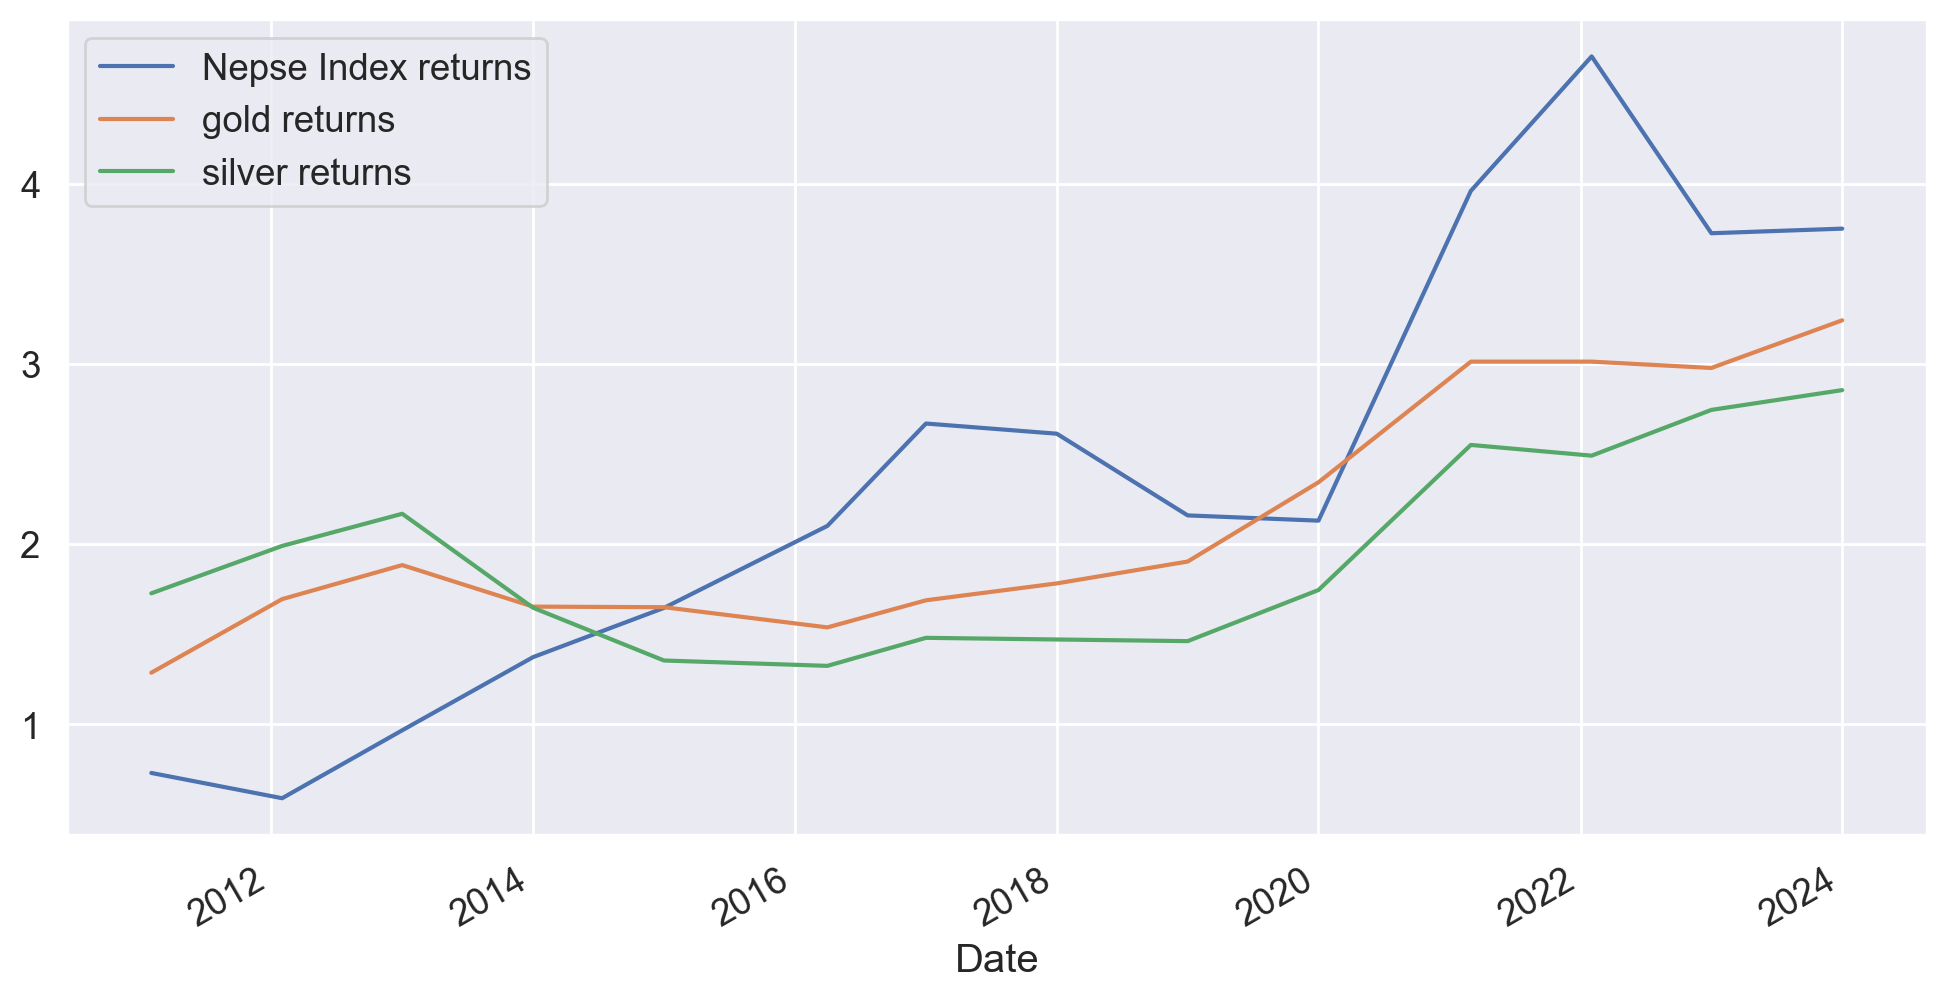

In [163]:
# plot 
plt.figure(figsize=(12,6))
(1+data_set['Nepse Index returns']).cumprod().plot()
(1+data_set['gold returns']).cumprod().plot()
(1+data_set['silver returns']).cumprod().plot()

plt.legend()

## Creating monthly returns heatmap

In [164]:
new_mlt_df = mlt_ret_df.pivot_table(values='NEPSE', index=mlt_ret_df.index.year, columns=mlt_ret_df.index.month)
new_mlt_df

Date,1,2,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011208,0.040207,0.001846,-0.062391
2002,-0.065950,-0.125734,-0.067006,0.071283,0.059545,-0.016804,-0.020884,0.012424,-0.043235,0.036179,-0.035892,-0.059224
2003,-0.004402,0.028103,0.026665,-0.026392,-0.000335,-0.016404,-0.011572,0.009986,0.007354,0.003965,-0.005442,-0.023969
2004,0.048718,-0.011921,-0.059989,0.045228,0.008869,0.056076,0.036908,0.047239,-0.013983,-0.008458,0.029251,-0.002637
2005,0.038273,0.075017,0.069068,0.034993,-0.048897,0.004466,0.052428,-0.007807,0.011581,0.029463,-0.016976,0.007453
2006,0.020675,0.103579,-0.010204,0.016915,0.082906,0.009146,0.009650,0.009188,0.031420,0.035840,0.190533,0.064316
2007,-0.007962,-0.002980,-0.060218,0.067985,0.053904,0.092855,0.147587,0.089194,0.187714,0.000581,0.020970,0.097226
2008,-0.183682,-0.058393,-0.062583,0.038145,0.131331,0.125159,0.103012,0.082802,-0.141937,-0.082094,-0.173826,-0.045390
2009,-0.052725,0.028368,-0.019763,-0.023324,0.107887,-0.078720,0.081399,-0.076962,-0.045836,-0.080834,-0.087563,0.036458


In [165]:
new_mlt_df.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
yearly_ret = mlt_ret_df.groupby(mlt_ret_df.index.year)['NEPSE'].sum()
new_mlt_df['years'] = yearly_ret

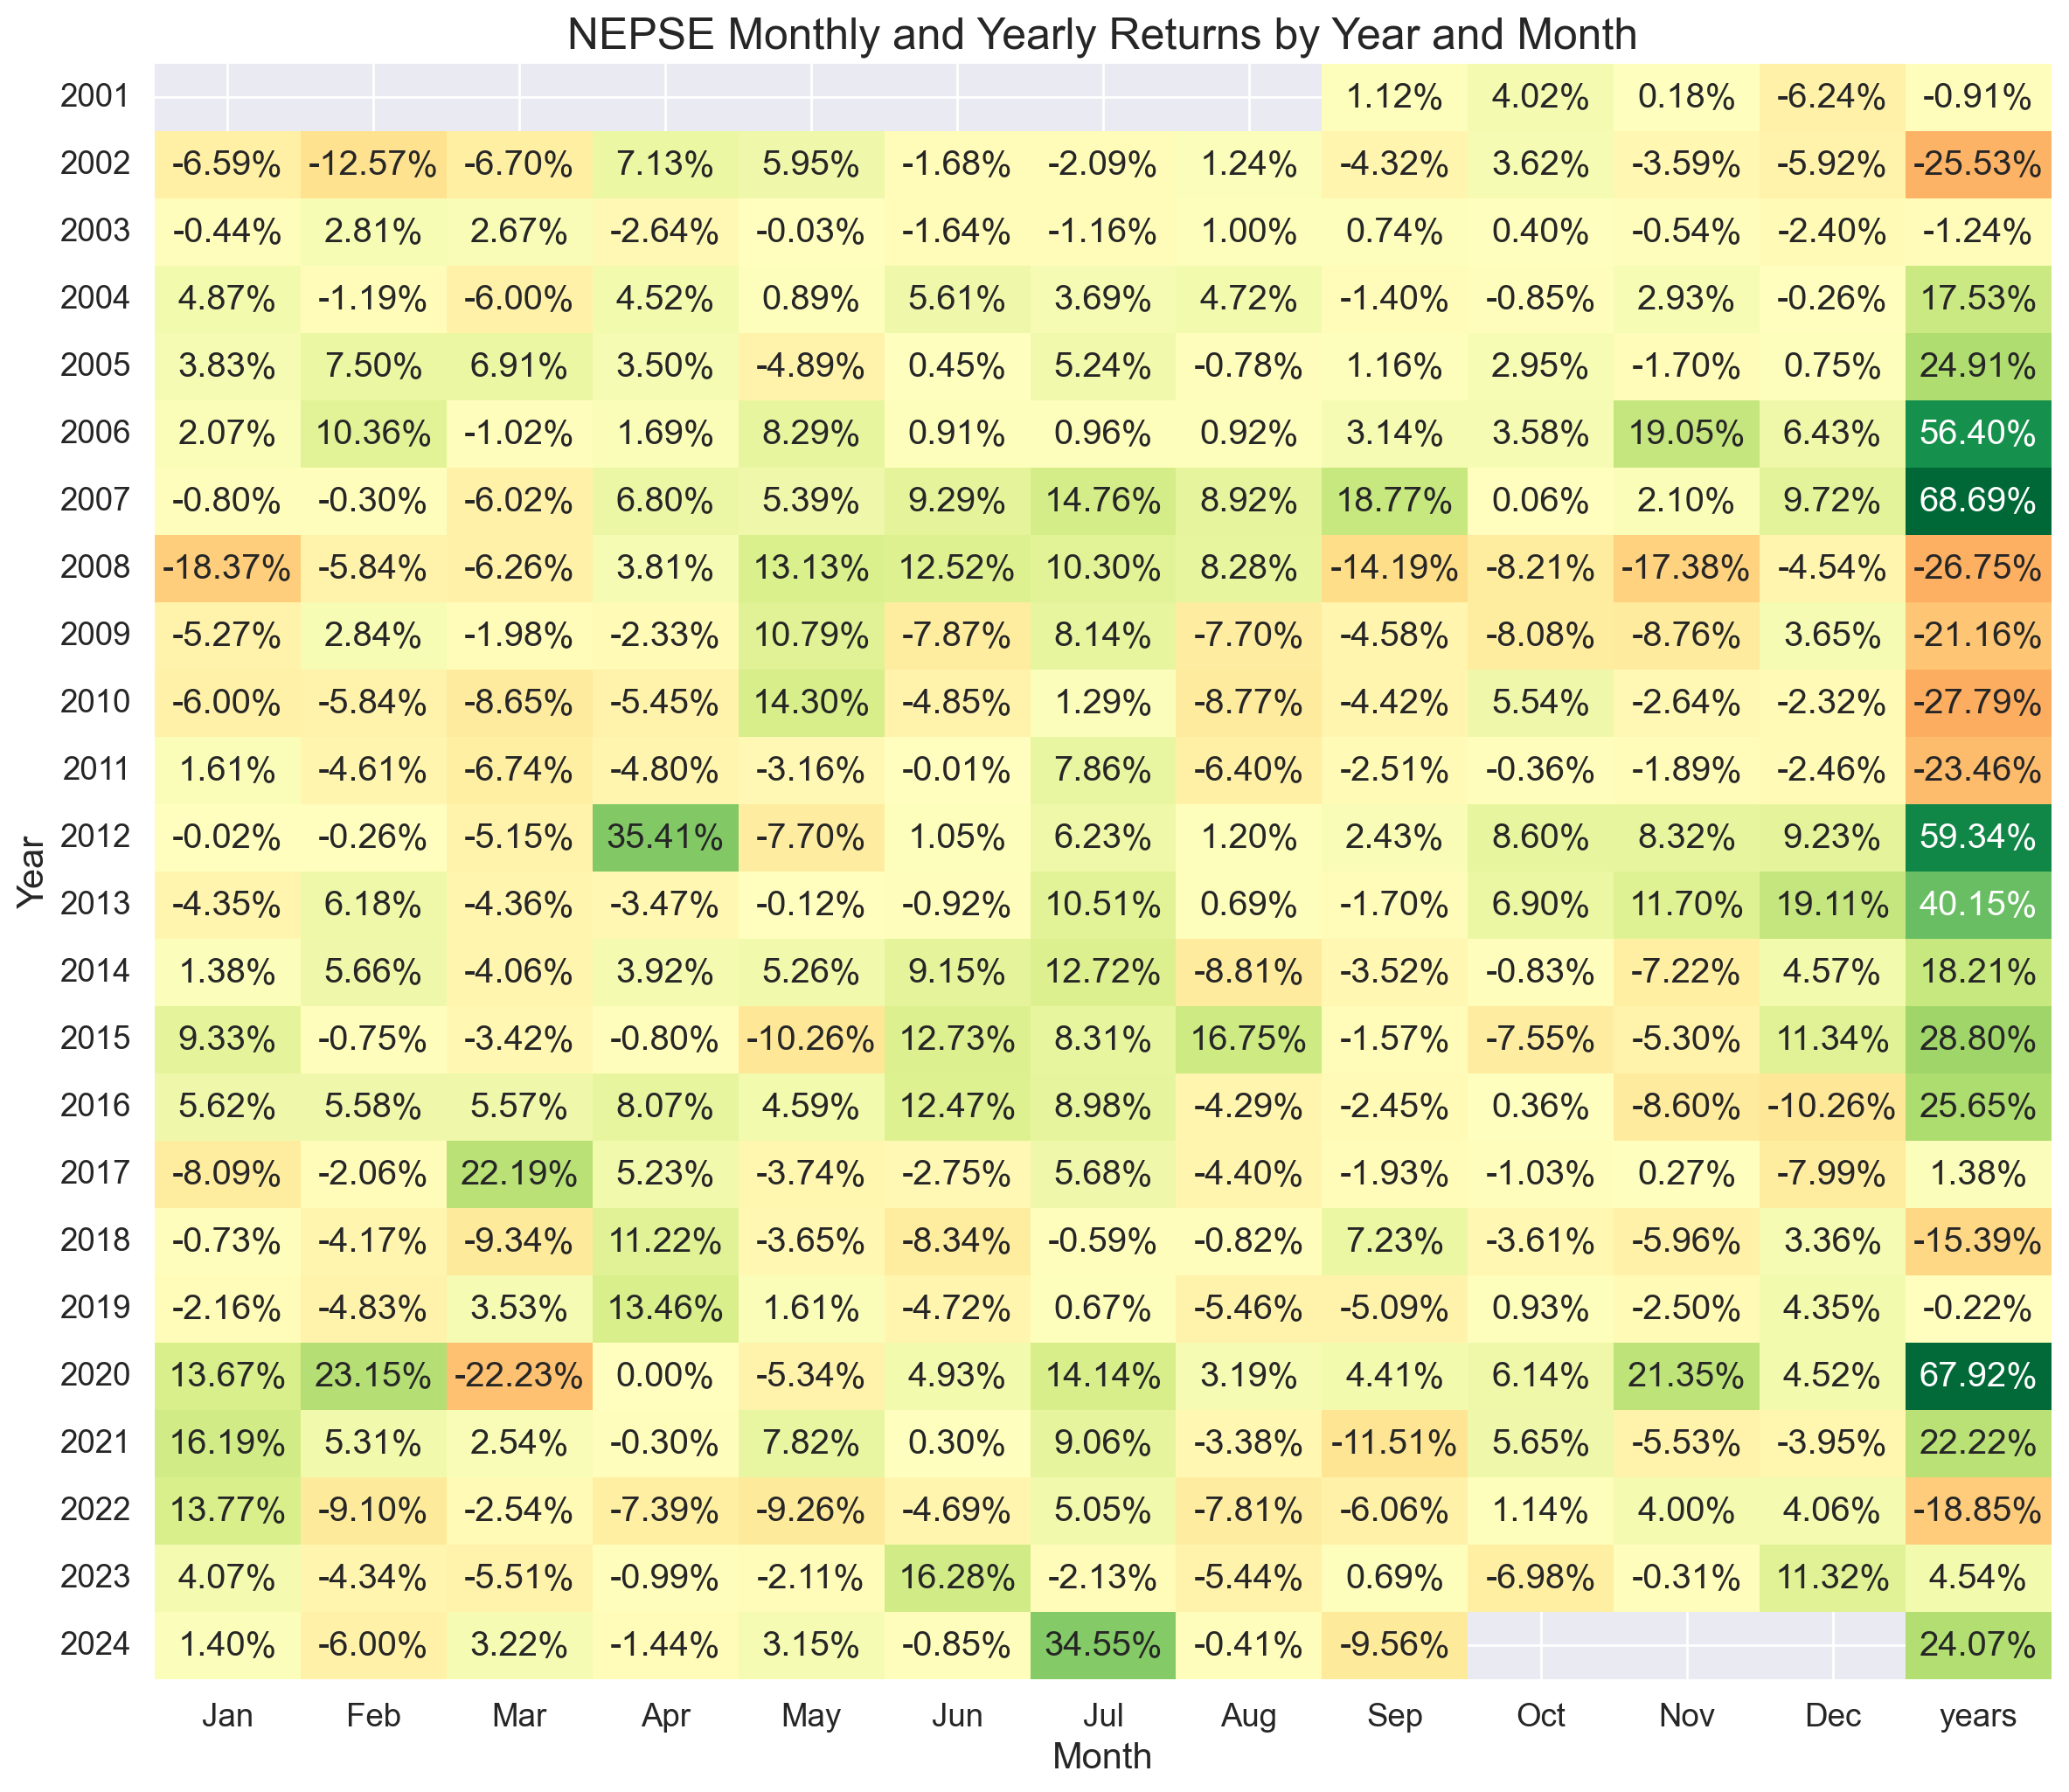

CPU times: user 1.55 s, sys: 144 ms, total: 1.7 s
Wall time: 856 ms


In [166]:
%%time
# Set the font scale
sns.set(font_scale=1.2)

# Plot the heatmap using seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(new_mlt_df, annot=True, center=0, fmt='.2%', cbar=False, cmap='RdYlGn')
plt.title('NEPSE Monthly and Yearly Returns by Year and Month', fontsize=18)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Year', fontsize=15)
plt.show()